In [ ]:
!nvidia-smi

Sun Sep 12 18:51:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    913MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

import math
import torch.utils.model_zoo as model_zoo
from torch.nn import Parameter
import pdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1_101-all-classes.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "All-classes-Full-UTK-CORAL_CDCNpp"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 101
BATCH_SIZE = 32
EPOCHS = 64 #200
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-13 00:51:27.615321+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: All-classes-Full-UTK-CORAL_CDCNpp
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_CDCNpp
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 32
Grayscale: False
Learning Rate: 0.0005
Epochs: 200


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
print(labels.size())

torch.Size([23689])


In [ ]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    # m = torch.zeros(uniq.shape[0])
    m = torch.zeros(int(torch.max(labels).item())) #tensor of 101 zeros

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq)+1)):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [ ]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [ ]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - label) #converting labels to levels..so if age is 22, 22 ones and (79-22) zeros, since total class is 101
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

**Dataset Entity Distribution Analysis**

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

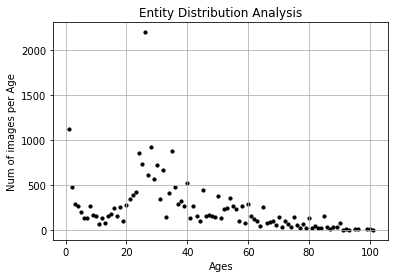

label		Age		Count
1 		 1 		 1123
2 		 2 		 482
3 		 3 		 289
4 		 4 		 273
5 		 5 		 196
6 		 6 		 131
7 		 7 		 139
8 		 8 		 263
9 		 9 		 166
10 		 10 		 156
11 		 11 		 65
12 		 12 		 130
13 		 13 		 81
14 		 14 		 157
15 		 15 		 177
16 		 16 		 247
17 		 17 		 158
18 		 18 		 262
19 		 19 		 98
20 		 20 		 284
21 		 21 		 346
22 		 22 		 395
23 		 23 		 426
24 		 24 		 859
25 		 25 		 734
26 		 26 		 2197
27 		 27 		 615
28 		 28 		 918
29 		 29 		 570
30 		 30 		 724
31 		 31 		 350
32 		 32 		 664
33 		 33 		 143
34 		 34 		 409
35 		 35 		 880
36 		 36 		 483
37 		 37 		 293
38 		 38 		 325
39 		 39 		 266
40 		 40 		 526
41 		 41 		 132
42 		 42 		 266
43 		 43 		 157
44 		 44 		 100
45 		 45 		 440
46 		 46 		 153
47 		 47 		 170
48 		 48 		 153
49 		 49 		 148
50 		 50 		 381
51 		 51 		 138
52 		 52 		 232
53 		 53 		 241
54 		 54 		 353
55 		 55 		 268
56 		 56 		 236
57 		 57 		 97
58 		 58 		 271
59 		 59 		 82
60 		 60 		 293
61 		 61 		 161
62 		 62 		 125
63 		 63 		

In [ ]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [ ]:
len(train_loader)

741

**Model**

In [ ]:
class Conv2d_cd(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(Conv2d_cd, self).__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal 
        else:
            #pdb.set_trace()
            [C_out,C_in, kernel_size,kernel_size] = self.conv.weight.shape
            kernel_diff = self.conv.weight.sum(2).sum(2)
            kernel_diff = kernel_diff[:, :, None, None]
            out_diff = F.conv2d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride, padding=0, groups=self.conv.groups)

            return out_normal - self.theta * out_diff
        
class SpatialAttention(nn.Module):
    def __init__(self, kernel = 3):
        super(SpatialAttention, self).__init__()


        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel, padding=kernel//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        
        return self.sigmoid(x)

class CDCN(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7):   
        super(CDCN, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),    
        )
        
        self.lastconv2 = nn.Sequential(
            basic_conv(128, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.lastconv3 = nn.Sequential(
            basic_conv(64, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )   
        
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')
        
        """newly added start"""
        self.fc_1024_512 = nn.Linear(in_features=1024, out_features=512)
        self.fc_512_1 = nn.Linear(in_features=512, out_features=1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES).float())
        """newly added end"""

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	# x [128, 128, 128]
        x_Block1_32x32 = self.downsample32x32(x_Block1)   # x [128, 32, 32]  
        
        x_Block2 = self.Block2(x_Block1)	    # x [128, 64, 64]	  
        x_Block2_32x32 = self.downsample32x32(x_Block2)   # x [128, 32, 32]  
        
        x_Block3 = self.Block3(x_Block2)	    # x [128, 32, 32]  	
        x_Block3_32x32 = self.downsample32x32(x_Block3)   # x [128, 32, 32]  
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    # x [128*3, 32, 32]  
        
        #pdb.set_trace()
        
        x = self.lastconv1(x_concat)    # x [128, 32, 32] 
        x = self.lastconv2(x)    # x [64, 32, 32] 
        x = self.lastconv3(x)    # x [1, 32, 32] 
        
        x = x.squeeze(1)

        """newly added start"""
        x = x.view(x.size(0), -1)
        x = self.fc_1024_512(x)
        x = F.relu(x)
        logits = self.fc_512_1(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)

        return logits, probas
        """newly added end"""
        
        # return map_x, x_concat, x_Block1, x_Block2, x_Block3, x_input


class CDCNpp(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7 ):   
        super(CDCNpp, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
            
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            basic_conv(128, int(128*1.6), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.6)),
            nn.ReLU(),  
            basic_conv(int(128*1.6), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            basic_conv(128, int(128*1.4), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.4)),
            nn.ReLU(),  
            basic_conv(int(128*1.4), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # Original
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            basic_conv(128, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )
        
      
        self.sa1 = SpatialAttention(kernel = 7)
        self.sa2 = SpatialAttention(kernel = 5)
        self.sa3 = SpatialAttention(kernel = 3)
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')

        """newly added start"""
        self.fc_1024_512 = nn.Linear(in_features=1024, out_features=512)
        self.fc_512_1 = nn.Linear(in_features=512, out_features=1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES).float())
        """newly added end"""

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	
        attention1 = self.sa1(x_Block1)
        x_Block1_SA = attention1 * x_Block1
        x_Block1_32x32 = self.downsample32x32(x_Block1_SA)   
        
        x_Block2 = self.Block2(x_Block1)	    
        attention2 = self.sa2(x_Block2)  
        x_Block2_SA = attention2 * x_Block2
        x_Block2_32x32 = self.downsample32x32(x_Block2_SA)  
        
        x_Block3 = self.Block3(x_Block2)	    
        attention3 = self.sa3(x_Block3)  
        x_Block3_SA = attention3 * x_Block3	
        x_Block3_32x32 = self.downsample32x32(x_Block3_SA)   
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    
        
        #pdb.set_trace()
        
        x = self.lastconv1(x_concat)
        x = x.squeeze(1)

        """newly added start"""
        x = x.view(x.size(0), -1)
        x = self.fc_1024_512(x)
        x = F.relu(x)
        logits = self.fc_512_1(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)

        return logits, probas
        """newly added end"""
        
        # return map_x, x_concat, attention1, attention2, attention3, x_input

**Initialise Model & Optimizer**

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
# model = CDCN()
model = CDCNpp()

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)
model.to(DEVICE)

optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

Params to learn:
	 linear_1_bias
	 conv1.0.conv.weight
	 conv1.1.weight
	 conv1.1.bias
	 Block1.0.conv.weight
	 Block1.1.weight
	 Block1.1.bias
	 Block1.3.conv.weight
	 Block1.4.weight
	 Block1.4.bias
	 Block1.6.conv.weight
	 Block1.7.weight
	 Block1.7.bias
	 Block2.0.conv.weight
	 Block2.1.weight
	 Block2.1.bias
	 Block2.3.conv.weight
	 Block2.4.weight
	 Block2.4.bias
	 Block2.6.conv.weight
	 Block2.7.weight
	 Block2.7.bias
	 Block2.9.conv.weight
	 Block2.10.weight
	 Block2.10.bias
	 Block3.0.conv.weight
	 Block3.1.weight
	 Block3.1.bias
	 Block3.3.conv.weight
	 Block3.4.weight
	 Block3.4.bias
	 Block3.6.conv.weight
	 Block3.7.weight
	 Block3.7.bias
	 lastconv1.0.conv.weight
	 lastconv1.1.weight
	 lastconv1.1.bias
	 lastconv1.3.conv.weight
	 sa1.conv1.weight
	 sa2.conv1.weight
	 sa3.conv1.weight
	 fc_1024_512.weight
	 fc_1024_512.bias
	 fc_512_1.weight


In [ ]:
print(model)

CDCNpp(
  (conv1): Sequential(
    (0): Conv2d_cd(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (Block1): Sequential(
    (0): Conv2d_cd(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d_cd(
      (conv): Conv2d(128, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d_cd(
      (conv): Conv2d(204, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2

In [ ]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits, probas = model(features)
    cost = cost_fn(logits, levels, imp)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

**Evaluataion**

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')